# PARTE 1: VALIDACIÓN CON IMÁGENES SINTÉTICAS

Este notebook realiza la validación del proceso de registro de imágenes utilizando imágenes sintéticas con transformaciones conocidas.


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import os
import sys
from datetime import datetime

plt.rcParams['figure.figsize'] = (10,6)


In [16]:
# Configurar carpetas de salida
# Ajustar ruta según donde se ejecute el notebook
project_root = os.path.abspath('..')
output_dir = os.path.join(project_root, 'data', 'synthetic')
os.makedirs(output_dir, exist_ok=True)

measurements_dir = os.path.join(project_root, 'results', 'measurements')
os.makedirs(measurements_dir, exist_ok=True)

# Clase para capturar y guardar todos los prints
class TeeOutput:
    def __init__(self, file_path):
        self.file = open(file_path, 'w', encoding='utf-8')
        self.stdout = sys.stdout
        self.write(f"=== EJECUCIÓN: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} ===\n\n")
    
    def write(self, text):
        # Escribir en stdout (para que se muestre en Jupyter)
        self.stdout.write(text)
        # Escribir en archivo
        self.file.write(text)
        self.file.flush()
    
    def flush(self):
        self.stdout.flush()
        self.file.flush()
    
    def close(self):
        self.file.close()
        if sys.stdout == self:
            sys.stdout = self.stdout

# Configurar archivo de salida (se sobrescribirá en cada ejecución)
log_file = os.path.join(measurements_dir, '1_validate_img_synthetic_results.txt')
tee = TeeOutput(log_file)

# Función helper para imprimir y guardar en archivo
def log_print(*args, **kwargs):
    """
    Imprime en consola y guarda en archivo simultáneamente.
    Similar a print() pero también escribe en el archivo de log.
    """
    # Convertir todos los argumentos a string y unirlos
    message = ' '.join(str(arg) for arg in args)
    # Manejar el parámetro 'end' si existe
    if 'end' in kwargs:
        message += kwargs['end']
    else:
        message += '\n'
    
    # Escribir tanto en consola como en archivo usando TeeOutput
    tee.write(message)


=== EJECUCIÓN: 2025-11-27 11:22:08 ===



## 1. Crear imagen sintética base


PASO 1: CREACIÓN DE IMAGEN SINTÉTICA BASE
Creando imagen sintética con formas geométricas para validación...

✓ Imagen sintética creada exitosamente:
  - Dimensiones: 400x400 píxeles
  - Tipo de datos: uint8
  - Canales: 3 (BGR)
  - Píxeles totales: 160,000
  - Elementos geométricos: rectángulo, círculo, línea, texto

  → Guardando imagen base...
  ✓ Imagen guardada correctamente


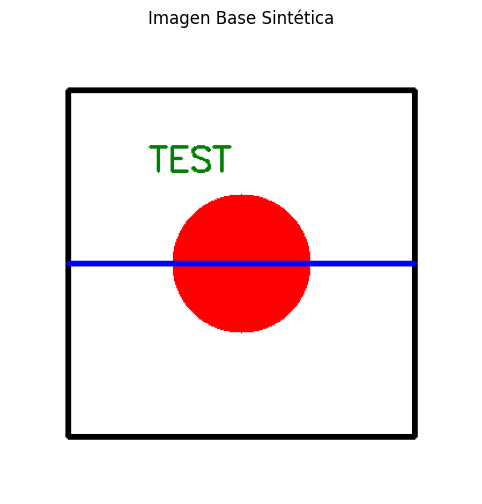

In [17]:
def create_synthetic_image(size=(400, 400)):
    """
    Crea una imagen sintética con formas geométricas para validación.
    
    La imagen contiene:
    - Fondo blanco
    - Rectángulo negro (bordes)
    - Círculo rojo (centro)
    - Línea azul horizontal
    - Texto verde "TEST"
    
    Esta imagen se usa como referencia para validar el proceso de registro,
    ya que tiene características distintivas que pueden ser detectadas después
    de aplicar transformaciones.
    """
    img = np.ones((size[0], size[1], 3), dtype=np.uint8) * 255
    cv2.rectangle(img, (50, 50), (350, 350), (0, 0, 0), 4)
    cv2.circle(img, (200, 200), 60, (0, 0, 255), -1)
    cv2.line(img, (50, 200), (350, 200), (255, 0, 0), 3)
    cv2.putText(img, "TEST", (120, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,128,0), 2)
    return img

log_print("=" * 60)
log_print("PASO 1: CREACIÓN DE IMAGEN SINTÉTICA BASE")
log_print("=" * 60)
log_print("Creando imagen sintética con formas geométricas para validación...")

base_img = create_synthetic_image()
log_print(f"\n✓ Imagen sintética creada exitosamente:")
log_print(f"  - Dimensiones: {base_img.shape[1]}x{base_img.shape[0]} píxeles")
log_print(f"  - Tipo de datos: {base_img.dtype}")
log_print(f"  - Canales: {base_img.shape[2]} (BGR)")
log_print(f"  - Píxeles totales: {base_img.shape[0]*base_img.shape[1]:,}")
log_print(f"  - Elementos geométricos: rectángulo, círculo, línea, texto")

# Guardar imagen
log_print(f"\n  → Guardando imagen base...")
base_img_path = os.path.join(output_dir, 'base_img.jpg')
cv2.imwrite(base_img_path, base_img)
log_print(f"  ✓ Imagen guardada correctamente")

plt.imshow(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB))
plt.title("Imagen Base Sintética")
plt.axis('off')
plt.show()
log_print("\n")


## 2. Aplicar transformaciones conocidas


PASO 2: APLICACIÓN DE TRANSFORMACIÓN CONOCIDA
Aplicando transformación conocida a la imagen base...
(Esta transformación será la referencia para validar la estimación)

✓ Parámetros de transformación configurados:
  - Rotación: 20°
  - Escala: 1.2x
  - Traslación X: 40 píxeles
  - Traslación Y: -15 píxeles
  - Centro de rotación: (200.0, 200.0)

  → Aplicando transformación...

✓ Imagen transformada generada:
  - Dimensiones: 400x400 píxeles
  - Píxeles totales: 160,000

  → Guardando imagen transformada...
  ✓ Imagen transformada guardada correctamente

✓ Homografía verdadera (H_true) calculada:
  [Esta es la transformación exacta que aplicamos]
  [La compararemos con la estimación para validar el algoritmo]

  Matriz H_true (3x3):
  [  1.12763114   0.41042417 -67.61106339]
  [-0.41042417  1.12763114 41.55860541]
  [0. 0. 1.]

  Parámetros extraídos de H_true:
  - Rotación aproximada: -20.00°
  - Escala aproximada: 1.2000
  - Traslación: (-67.61, 41.56) píxeles


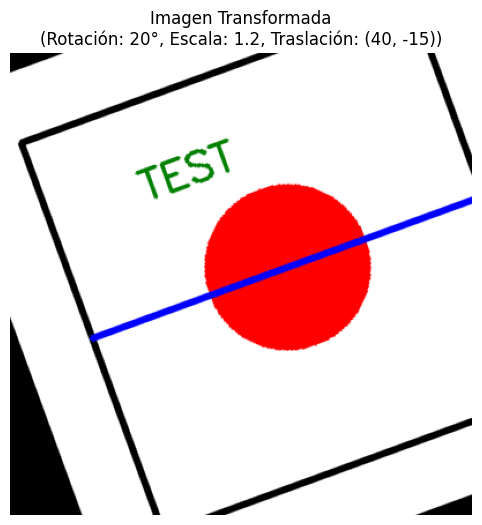

In [18]:
def apply_known_transform(img, angle=15, scale=1.1, tx=30, ty=20):
    """
    Aplica una transformación afín conocida a una imagen.
    
    Transformación compuesta de:
    - Rotación alrededor del centro
    - Escalado uniforme
    - Traslación en X e Y
    
    Esta función es crucial para la validación porque conocemos exactamente
    qué transformación se aplicó, lo que nos permite compararla con la estimación.
    """
    h, w = img.shape[:2]
    center = (w/2, h/2)
    # Crear matriz de transformación (rotación + escala)
    M_rot = cv2.getRotationMatrix2D(center, angle, scale)
    # Agregar traslación
    M_rot[:,2] += [tx, ty]
    # Aplicar transformación
    transformed = cv2.warpAffine(img, M_rot, (w, h))
    # Convertir a homografía 3x3 (forma estándar para comparación)
    H_true = np.vstack([M_rot, [0,0,1]])
    return transformed, H_true

log_print("=" * 60)
log_print("PASO 2: APLICACIÓN DE TRANSFORMACIÓN CONOCIDA")
log_print("=" * 60)
log_print("Aplicando transformación conocida a la imagen base...")
log_print("(Esta transformación será la referencia para validar la estimación)")

# Parámetros de transformación
angle, scale, tx, ty = 20, 1.2, 40, -15
log_print(f"\n✓ Parámetros de transformación configurados:")
log_print(f"  - Rotación: {angle}°")
log_print(f"  - Escala: {scale}x")
log_print(f"  - Traslación X: {tx} píxeles")
log_print(f"  - Traslación Y: {ty} píxeles")
log_print(f"  - Centro de rotación: ({base_img.shape[1]/2:.1f}, {base_img.shape[0]/2:.1f})")

log_print(f"\n  → Aplicando transformación...")
trans_img, H_true = apply_known_transform(base_img, angle, scale, tx, ty)

log_print(f"\n✓ Imagen transformada generada:")
log_print(f"  - Dimensiones: {trans_img.shape[1]}x{trans_img.shape[0]} píxeles")
log_print(f"  - Píxeles totales: {trans_img.shape[0]*trans_img.shape[1]:,}")

# Guardar imagen transformada
log_print(f"\n  → Guardando imagen transformada...")
trans_img_path = os.path.join(output_dir, 'trans_img.jpg')
cv2.imwrite(trans_img_path, trans_img)
log_print(f"  ✓ Imagen transformada guardada correctamente")

log_print(f"\n✓ Homografía verdadera (H_true) calculada:")
log_print("  [Esta es la transformación exacta que aplicamos]")
log_print("  [La compararemos con la estimación para validar el algoritmo]")
log_print(f"\n  Matriz H_true (3x3):")
log_print(f"  {H_true[0]}")
log_print(f"  {H_true[1]}")
log_print(f"  {H_true[2]}")
log_print(f"\n  Parámetros extraídos de H_true:")
log_print(f"  - Rotación aproximada: {np.degrees(np.arctan2(H_true[1,0], H_true[0,0])):.2f}°")
log_print(f"  - Escala aproximada: {np.linalg.norm(H_true[0:2,0]):.4f}")
log_print(f"  - Traslación: ({H_true[0,2]:.2f}, {H_true[1,2]:.2f}) píxeles")

plt.imshow(cv2.cvtColor(trans_img, cv2.COLOR_BGR2RGB))
plt.title(f"Imagen Transformada\n(Rotación: {angle}°, Escala: {scale}, Traslación: ({tx}, {ty}))")
plt.axis('off')
plt.show()
log_print("\n")


## 3. Detección de puntos y estimación de homografía


In [19]:
def get_detector():
    """
    Obtiene un detector de características, intentando usar SIFT primero.
    Si SIFT no está disponible, usa ORB como alternativa.
    """
    try:
        detector = cv2.SIFT_create()
        return detector, 'SIFT'
    except:
        return cv2.ORB_create(1000), 'ORB'

def estimate_homography(img1, img2):
    """
    Estima la homografía entre dos imágenes mediante detección de características.
    
    Proceso:
    1. Detección de keypoints y cálculo de descriptores
    2. Matching con ratio test (ratio=0.75)
    3. Estimación de homografía con RANSAC (umbral=5.0 px)
    
    Esta función simula el proceso de registro que usaremos en imágenes reales.
    """
    log_print(f"  → Obteniendo detector de características...")
    detector, method = get_detector()
    log_print(f"    ✓ Detector {method} seleccionado")
    
    log_print(f"  → Detectando características en imagen 1...")
    kp1, des1 = detector.detectAndCompute(img1, None)
    log_print(f"    ✓ Encontrados {len(kp1)} puntos clave en imagen 1")
    
    log_print(f"  → Detectando características en imagen 2...")
    kp2, des2 = detector.detectAndCompute(img2, None)
    log_print(f"    ✓ Encontrados {len(kp2)} puntos clave en imagen 2")
    
    if des1 is None or des2 is None:
        log_print(f"    ⚠ No se pudieron detectar suficientes características")
        return None, None, None, [], method, kp1, kp2, None, 0
    
    # Seleccionar matcher según el tipo de descriptor
    if method == 'SIFT':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        if des1.dtype != np.float32:
            des1 = des1.astype(np.float32)
            des2 = des2.astype(np.float32)
    else:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    
    log_print(f"  → Buscando correspondencias entre imágenes...")
    matches = matcher.knnMatch(des1, des2, k=2)
    log_print(f"    ✓ Encontrados {len(matches)} matches iniciales (k=2)")
    
    # Ratio test de Lowe: solo aceptar matches donde el mejor match es 
    # significativamente mejor que el segundo mejor
    good = [m for m,n in matches if m.distance < 0.75*n.distance]
    log_print(f"    ✓ Después del ratio test (0.75): {len(good)} matches válidos")
    if len(matches) > 0:
        log_print(f"    ✓ Tasa de retención: {len(good)/len(matches)*100:.1f}%")
    
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])
    
    if len(pts1) < 4:
        log_print(f"    ⚠ No hay suficientes matches ({len(pts1)} < 4) para estimar homografía")
        return None, pts1, pts2, good, method, kp1, kp2, None, len(matches)
    
    log_print(f"  → Estimando homografía con RANSAC (umbral=5.0 px)...")
    H_est, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)
    
    if H_est is not None and mask is not None:
        num_inliers = int(mask.sum())
        log_print(f"    ✓ Homografía estimada: {num_inliers} inliers de {len(good)} matches")
        if len(good) > 0:
            log_print(f"    ✓ Tasa de inliers: {num_inliers/len(good)*100:.1f}%")
    else:
        log_print(f"    ✗ No se pudo estimar la homografía")
    
    return H_est, pts1, pts2, good, method, kp1, kp2, mask, len(matches)

log_print("=" * 60)
log_print("PASO 3: DETECCIÓN DE PUNTOS Y ESTIMACIÓN DE HOMOGRAFÍA")
log_print("=" * 60)
log_print("Estimando la homografía entre imagen base e imagen transformada...")
log_print("(Este es el proceso que queremos validar)")

H_est, pts1, pts2, good, method, kp1, kp2, mask, num_matches = estimate_homography(base_img, trans_img)

log_print(f"\n✓ Resumen del proceso de estimación:")
log_print(f"  - Detector utilizado: {method}")
log_print(f"  - Keypoints detectados: {len(kp1)} en imagen base, {len(kp2)} en imagen transformada")
log_print(f"  - Matches iniciales: {num_matches}")
log_print(f"  - Matches válidos (ratio test): {len(good)}")
if mask is not None:
    num_inliers = int(mask.sum())
    log_print(f"  - Inliers (RANSAC): {num_inliers}")

if H_est is not None:
    log_print(f"\n✓ Homografía estimada (H_est) calculada exitosamente:")
    log_print("  [Esta es la transformación que el algoritmo estimó automáticamente]")
    log_print(f"\n  Matriz H_est (3x3):")
    log_print(f"  {H_est[0]}")
    log_print(f"  {H_est[1]}")
    log_print(f"  {H_est[2]}")
    
    log_print(f"\n  Parámetros extraídos de H_est:")
    rot_est = np.degrees(np.arctan2(H_est[1,0], H_est[0,0]))
    scale_est = np.linalg.norm(H_est[0:2,0])
    log_print(f"  - Rotación estimada: {rot_est:.2f}°")
    log_print(f"  - Escala estimada: {scale_est:.4f}")
    log_print(f"  - Traslación estimada: ({H_est[0,2]:.2f}, {H_est[1,2]:.2f}) píxeles")
else:
    log_print(f"\n✗ No se pudo estimar la homografía")
    log_print(f"  Esto puede deberse a:")
    log_print(f"  - Insuficientes características detectadas")
    log_print(f"  - Poca superposición entre imágenes")
    log_print(f"  - Transformación demasiado extrema")

log_print("\n")


PASO 3: DETECCIÓN DE PUNTOS Y ESTIMACIÓN DE HOMOGRAFÍA
Estimando la homografía entre imagen base e imagen transformada...
(Este es el proceso que queremos validar)
  → Obteniendo detector de características...
    ✓ Detector SIFT seleccionado
  → Detectando características en imagen 1...
    ✓ Encontrados 59 puntos clave en imagen 1
  → Detectando características en imagen 2...
    ✓ Encontrados 162 puntos clave en imagen 2
  → Buscando correspondencias entre imágenes...
    ✓ Encontrados 59 matches iniciales (k=2)
    ✓ Después del ratio test (0.75): 37 matches válidos
    ✓ Tasa de retención: 62.7%
  → Estimando homografía con RANSAC (umbral=5.0 px)...
    ✓ Homografía estimada: 25 inliers de 37 matches
    ✓ Tasa de inliers: 67.6%

✓ Resumen del proceso de estimación:
  - Detector utilizado: SIFT
  - Keypoints detectados: 59 en imagen base, 162 en imagen transformada
  - Matches iniciales: 59
  - Matches válidos (ratio test): 37
  - Inliers (RANSAC): 25

✓ Homografía estimada (H_est

## 4. Comparar transformaciones: métricas


In [20]:
def compare_homographies(H_true, H_est):
    """
    Compara dos homografías y calcula métricas de error.
    
    Métricas calculadas:
    1. RMSE: Error cuadrático medio en transformación de esquinas
    2. Error angular: Diferencia en rotación
    3. Error de escala: Diferencia porcentual en escala
    """
    # Normalizar homografías
    H_true_norm = H_true.copy() / H_true[2,2]
    H_est_norm = H_est.copy() / H_est[2,2]
    
    # 4 puntos de referencia (esquinas de imagen 400x400)
    pts = np.float32([[0,0],[399,0],[399,399],[0,399]]).reshape(-1,1,2)
    pts_true = cv2.perspectiveTransform(pts, H_true_norm)
    pts_est = cv2.perspectiveTransform(pts, H_est_norm)
    
    # Calcular errores por punto
    errors_per_point = np.sqrt(np.sum((pts_true - pts_est)**2, axis=2))
    rmse = np.sqrt(np.mean(errors_per_point**2))
    
    # Error de rotación
    R_true = H_true_norm[:2,:2] / np.linalg.norm(H_true_norm[0,:2])
    R_est = H_est_norm[:2,:2] / np.linalg.norm(H_est_norm[0,:2])
    cos_theta = np.clip(np.trace(R_true.T @ R_est)/2, -1, 1)
    ang_error = np.degrees(np.arccos(cos_theta))
    
    # Error de escala
    s_true = np.linalg.norm(H_true_norm[0:2,0])
    s_est = np.linalg.norm(H_est_norm[0:2,0])
    scale_error = abs(s_est - s_true)/s_true * 100
    
    return rmse, ang_error, scale_error, errors_per_point, pts_true, pts_est

log_print("=" * 60)
log_print("PASO 4: COMPARACIÓN DE TRANSFORMACIONES - MÉTRICAS")
log_print("=" * 60)
log_print("Comparando la homografía verdadera (H_true) con la estimada (H_est)...")
log_print("(Aquí validamos qué tan preciso es el algoritmo de registro)")

if H_est is not None:
    rmse, ang_err, scale_err, errors_per_point, pts_true, pts_est = compare_homographies(H_true, H_est)
    
    log_print(f"\n✓ Métricas de error calculadas:")
    log_print(f"\n  1. RMSE (Root Mean Square Error):")
    log_print(f"     - Valor: {rmse:.4f} píxeles")
    log_print(f"     - Interpretación: Error promedio en la transformación de las esquinas")
    log_print(f"     - Errores por esquina:")
    corner_names = ['Esquina superior-izquierda', 'Esquina superior-derecha', 
                    'Esquina inferior-derecha', 'Esquina inferior-izquierda']
    for i, (name, err) in enumerate(zip(corner_names, errors_per_point.flatten())):
        log_print(f"       {name}: {err:.4f} px")
    
    log_print(f"\n  2. Error angular:")
    log_print(f"     - Valor: {ang_err:.4f}°")
    rot_true = angle
    rot_est = np.degrees(np.arctan2(H_est[1,0], H_est[0,0]))
    log_print(f"     - Rotación verdadera: {rot_true}°")
    log_print(f"     - Rotación estimada: {rot_est:.4f}°")
    log_print(f"     - Diferencia: {abs(rot_true - rot_est):.4f}°")
    
    log_print(f"\n  3. Error de escala:")
    log_print(f"     - Valor: {scale_err:.3f}%")
    s_true = np.linalg.norm(H_true[0:2,0])
    s_est = np.linalg.norm(H_est[0:2,0])
    log_print(f"     - Escala verdadera: {s_true:.4f}")
    log_print(f"     - Escala estimada: {s_est:.4f}")
    log_print(f"     - Diferencia absoluta: {abs(s_est - s_true):.4f}")
    
    log_print(f"\n✓ Resumen de precisión del algoritmo:")
    log_print(f"  - RMSE: {rmse:.4f} px")
    log_print(f"  - Error angular: {ang_err:.4f}°")
    log_print(f"  - Error de escala: {scale_err:.3f}%")
    
    # Evaluación cualitativa
    log_print(f"\n✓ Evaluación cualitativa de la precisión:")
    rmse_status = "EXCELENTE" if rmse < 50 else ("BUENO" if rmse < 100 else ("ACEPTABLE" if rmse < 200 else "ALTO"))
    rmse_label = "< 50 px" if rmse < 50 else ("50-100 px" if rmse < 100 else ("100-200 px" if rmse < 200 else "> 200 px"))
    log_print(f"  - RMSE: {rmse_status} ({rmse_label})")
    
    ang_status = "EXCELENTE" if ang_err < 5 else ("BUENO" if ang_err < 15 else "ALTO")
    ang_label = "< 5°" if ang_err < 5 else ("5-15°" if ang_err < 15 else "> 15°")
    log_print(f"  - Error angular: {ang_status} ({ang_label})")
    
    scale_status = "EXCELENTE" if scale_err < 5 else ("BUENO" if scale_err < 15 else "ALTO")
    scale_label = "< 5%" if scale_err < 5 else ("5-15%" if scale_err < 15 else "> 15%")
    log_print(f"  - Error de escala: {scale_status} ({scale_label})")
else:
    log_print("\n✗ No se pudo estimar la homografía. No se pueden calcular métricas.")
log_print("\n")


PASO 4: COMPARACIÓN DE TRANSFORMACIONES - MÉTRICAS
Comparando la homografía verdadera (H_true) con la estimada (H_est)...
(Aquí validamos qué tan preciso es el algoritmo de registro)

✓ Métricas de error calculadas:

  1. RMSE (Root Mean Square Error):
     - Valor: 231.6236 píxeles
     - Interpretación: Error promedio en la transformación de las esquinas
     - Errores por esquina:
       Esquina superior-izquierda: 142.8801 px
       Esquina superior-derecha: 223.4999 px
       Esquina inferior-derecha: 292.9465 px
       Esquina inferior-izquierda: 241.6886 px

  2. Error angular:
     - Valor: 39.8847°
     - Rotación verdadera: 20°
     - Rotación estimada: 19.9988°
     - Diferencia: 0.0012°

  3. Error de escala:
     - Valor: 30.905%
     - Escala verdadera: 1.2000
     - Escala estimada: 0.8291
     - Diferencia absoluta: 0.3709

✓ Resumen de precisión del algoritmo:
  - RMSE: 231.6236 px
  - Error angular: 39.8847°
  - Error de escala: 30.905%

✓ Evaluación cualitativa de la

## 5. Visualizar coincidencias


PASO 5: VISUALIZACIÓN DE COINCIDENCIAS
Generando visualización de los matches detectados entre imágenes...

✓ Preparando visualización:
  - Total de matches válidos: 37
  - Matches a mostrar: 30 (para mejor visualización)

  → Detectando keypoints para visualización...
    ✓ Keypoints listos para visualización

  → Creando imagen de matches...
  → Guardando imagen de matches...
    ✓ Imagen de matches guardada correctamente


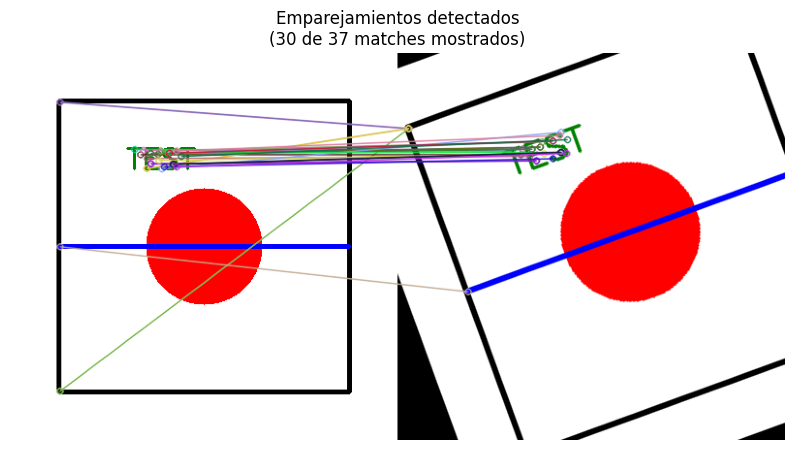

In [21]:
log_print("=" * 60)
log_print("PASO 5: VISUALIZACIÓN DE COINCIDENCIAS")
log_print("=" * 60)
log_print("Generando visualización de los matches detectados entre imágenes...")

log_print(f"\n✓ Preparando visualización:")
log_print(f"  - Total de matches válidos: {len(good)}")
num_matches_vis = min(30, len(good))
log_print(f"  - Matches a mostrar: {num_matches_vis} (para mejor visualización)")

# Detectar keypoints para visualización
log_print(f"\n  → Detectando keypoints para visualización...")
detector_vis, _ = get_detector()
kp1_vis = detector_vis.detect(base_img, None)
kp2_vis = detector_vis.detect(trans_img, None)
log_print(f"    ✓ Keypoints listos para visualización")

log_print(f"\n  → Creando imagen de matches...")
match_vis = cv2.drawMatches(base_img, kp1_vis,
                            trans_img, kp2_vis,
                            good[:30], None, 
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

log_print(f"  → Guardando imagen de matches...")
matches_path = os.path.join(output_dir, 'matches.jpg')
cv2.imwrite(matches_path, match_vis)
log_print(f"    ✓ Imagen de matches guardada correctamente")

plt.imshow(cv2.cvtColor(match_vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Emparejamientos detectados\n({num_matches_vis} de {len(good)} matches mostrados)")
plt.show()
log_print("\n")


## 6. Experimento: evaluar parámetros


In [22]:
log_print("=" * 60)
log_print("PASO 6: EXPERIMENTO - EVALUACIÓN DE PARÁMETROS")
log_print("=" * 60)
log_print("Ejecutando experimento sistemático con múltiples transformaciones...")
log_print("(Esto nos permite evaluar el rendimiento del algoritmo en diferentes condiciones)")

angles = [5, 15, 30, 45]
scales = [1.0, 1.1, 1.3]
tx, ty = 30, 20  # Traslación fija para todos los experimentos

log_print(f"\n✓ Configuración del experimento:")
log_print(f"  - Ángulos a probar: {angles}°")
log_print(f"  - Escalas a probar: {scales}")
log_print(f"  - Traslación fija: ({tx}, {ty}) píxeles")
total_combinations = len(angles) * len(scales)
log_print(f"  - Total de combinaciones: {total_combinations}")

results = []
log_print(f"\n✓ Procesando {total_combinations} combinaciones de parámetros...")
log_print(f"  (Esto puede tomar unos momentos)")

for idx, (a, s) in enumerate([(a, s) for a in angles for s in scales], 1):
    log_print(f"\n  {'─'*55}")
    log_print(f"  Combinación {idx}/{total_combinations}: Ángulo={a}°, Escala={s}")
    log_print(f"  {'─'*55}")
    
    # Aplicar transformación conocida
    log_print(f"    → Aplicando transformación...")
    img_t, Ht = apply_known_transform(base_img, angle=a, scale=s, tx=tx, ty=ty)
    
    # Guardar imagen transformada
    log_print(f"    → Guardando imagen transformada...")
    img_path = os.path.join(output_dir, f'transformed_a{a}_s{s:.1f}.jpg')
    cv2.imwrite(img_path, img_t)
    log_print(f"      ✓ Imagen guardada")
     
    # Estimar homografía
    log_print(f"    → Estimando homografía...")
    Hest, pts1_est, pts2_est, good_est, method_est, _, _, mask_est, _ = estimate_homography(base_img, img_t)
     
    if Hest is not None:
        rmse, ang_err, scale_err, _, _, _ = compare_homographies(Ht, Hest)
        num_inliers = int(mask_est.sum()) if mask_est is not None else 0
        results.append((a, s, rmse, ang_err, scale_err, len(good_est), num_inliers))
        log_print(f"    ✓ Resultado exitoso:")
        log_print(f"      - Matches: {len(good_est)}, Inliers: {num_inliers}")
        log_print(f"      - RMSE: {rmse:.3f} px")
        log_print(f"      - Error angular: {ang_err:.3f}°")
        log_print(f"      - Error escala: {scale_err:.3f}%")
    else:
        results.append((a, s, np.inf, np.inf, np.inf, 0, 0))
        log_print(f"    ✗ Falló: No se pudo estimar homografía")

log_print(f"\n{'='*60}")
log_print("RESUMEN DE RESULTADOS DEL EXPERIMENTO")
log_print(f"{'='*60}")

log_print(f"\n✓ Tabla de resultados completos:")
log_print("-" * 80)
log_print(f"{'Ángulo':>8} | {'Escala':>8} | {'RMSE (px)':>12} | {'Error Rot (°)':>15} | {'Error Escala (%)':>18} | {'Matches':>10} | {'Inliers':>10}")
log_print("-" * 80)

for r in results:
    if r[2] != np.inf:
        log_print(f"{r[0]:>8.1f} | {r[1]:>8.2f} | {r[2]:>12.3f} | {r[3]:>15.3f} | {r[4]:>18.3f} | {r[5]:>10} | {r[6]:>10}")
    else:
        log_print(f"{r[0]:>8.1f} | {r[1]:>8.2f} | {'FALLÓ':>12} | {'FALLÓ':>15} | {'FALLÓ':>18} | {r[5]:>10} | {r[6]:>10}")

# Análisis de resultados
valid_results = [r for r in results if r[2] != np.inf]
log_print("-" * 80)

if valid_results:
    log_print(f"\n✓ Análisis estadístico de {len(valid_results)} casos exitosos:")
    rmse_values = [r[2] for r in valid_results]
    ang_err_values = [r[3] for r in valid_results]
    scale_err_values = [r[4] for r in valid_results]
    
    log_print(f"\n  RMSE (Root Mean Square Error):")
    best_rmse_idx = np.argmin(rmse_values)
    worst_rmse_idx = np.argmax(rmse_values)
    log_print(f"    - Mínimo: {min(rmse_values):.3f} px (Ángulo={valid_results[best_rmse_idx][0]}°, Escala={valid_results[best_rmse_idx][1]})")
    log_print(f"    - Máximo: {max(rmse_values):.3f} px (Ángulo={valid_results[worst_rmse_idx][0]}°, Escala={valid_results[worst_rmse_idx][1]})")
    log_print(f"    - Promedio: {np.mean(rmse_values):.3f} px")
    log_print(f"    - Desviación estándar: {np.std(rmse_values):.3f} px")
    
    log_print(f"\n  Error angular:")
    best_ang_idx = np.argmin(ang_err_values)
    worst_ang_idx = np.argmax(ang_err_values)
    log_print(f"    - Mínimo: {min(ang_err_values):.3f}° (Ángulo={valid_results[best_ang_idx][0]}°, Escala={valid_results[best_ang_idx][1]})")
    log_print(f"    - Máximo: {max(ang_err_values):.3f}° (Ángulo={valid_results[worst_ang_idx][0]}°, Escala={valid_results[worst_ang_idx][1]})")
    log_print(f"    - Promedio: {np.mean(ang_err_values):.3f}°")
    
    log_print(f"\n  Error de escala:")
    best_scale_idx = np.argmin(scale_err_values)
    worst_scale_idx = np.argmax(scale_err_values)
    log_print(f"    - Mínimo: {min(scale_err_values):.3f}% (Ángulo={valid_results[best_scale_idx][0]}°, Escala={valid_results[best_scale_idx][1]})")
    log_print(f"    - Máximo: {max(scale_err_values):.3f}% (Ángulo={valid_results[worst_scale_idx][0]}°, Escala={valid_results[worst_scale_idx][1]})")
    log_print(f"    - Promedio: {np.mean(scale_err_values):.3f}%")
    
    log_print(f"\n✓ Conclusiones principales:")
    best_rmse = valid_results[best_rmse_idx]
    worst_rmse = valid_results[worst_rmse_idx]
    log_print(f"  - Mejor resultado (menor RMSE): Ángulo={best_rmse[0]}°, Escala={best_rmse[1]}")
    log_print(f"    → RMSE: {best_rmse[2]:.3f} px, Error angular: {best_rmse[3]:.3f}°, Error escala: {best_rmse[4]:.3f}%")
    log_print(f"  - Peor resultado (mayor RMSE): Ángulo={worst_rmse[0]}°, Escala={worst_rmse[1]}")
    log_print(f"    → RMSE: {worst_rmse[2]:.3f} px, Error angular: {worst_rmse[3]:.3f}°, Error escala: {worst_rmse[4]:.3f}%")
    
    # Análisis por ángulo
    log_print(f"\n  Análisis de rendimiento por ángulo:")
    for angle in angles:
        angle_results = [r for r in valid_results if r[0] == angle]
        if angle_results:
            avg_rmse = np.mean([r[2] for r in angle_results])
            avg_ang = np.mean([r[3] for r in angle_results])
            log_print(f"    Ángulo {angle}°: RMSE promedio = {avg_rmse:.3f} px, Error angular promedio = {avg_ang:.3f}°")
    
    # Análisis por escala
    log_print(f"\n  Análisis de rendimiento por escala:")
    for scale in scales:
        scale_results = [r for r in valid_results if r[1] == scale]
        if scale_results:
            avg_rmse = np.mean([r[2] for r in scale_results])
            avg_scale_err = np.mean([r[4] for r in scale_results])
            log_print(f"    Escala {scale}: RMSE promedio = {avg_rmse:.3f} px, Error de escala promedio = {avg_scale_err:.3f}%")
else:
    log_print(f"\n✗ No se obtuvieron resultados válidos en el experimento")

log_print("\n")


PASO 6: EXPERIMENTO - EVALUACIÓN DE PARÁMETROS
Ejecutando experimento sistemático con múltiples transformaciones...
(Esto nos permite evaluar el rendimiento del algoritmo en diferentes condiciones)

✓ Configuración del experimento:
  - Ángulos a probar: [5, 15, 30, 45]°
  - Escalas a probar: [1.0, 1.1, 1.3]
  - Traslación fija: (30, 20) píxeles
  - Total de combinaciones: 12

✓ Procesando 12 combinaciones de parámetros...
  (Esto puede tomar unos momentos)

  ───────────────────────────────────────────────────────
  Combinación 1/12: Ángulo=5°, Escala=1.0
  ───────────────────────────────────────────────────────
    → Aplicando transformación...
    → Guardando imagen transformada...
      ✓ Imagen guardada
    → Estimando homografía...
  → Obteniendo detector de características...
    ✓ Detector SIFT seleccionado
  → Detectando características en imagen 1...
    ✓ Encontrados 59 puntos clave en imagen 1
  → Detectando características en imagen 2...
    ✓ Encontrados 130 puntos clave e

In [23]:
# Cerrar el archivo de salida
tee.close()
